<span style="font-size:3rem"><strong>Who reviews the reviews?</strong></span>

<h1>Table of Contents<span class="tocSkip"></span></h1>


<div class="toc">
  <ul class="toc-item">
    <li><span><a href="#Introduction" data-toc-modified-id="Introduction"><span class="toc-item-num"></span>Introduction</a></span>
    </li>
    <li><span><a href="#Load-Data" data-toc-modified-id="Load"><span class="toc-item-num"></span>Load Data</a></span>
    </li>
     <li><span><a href="#Exploration" data-toc-modified-id="Cleaning"><span class="toc-item-num"></span>Cleaning</a></span>
    </li>
     <li><span><a href="#Exploration" data-toc-modified-id="Exploration"><span class="toc-item-num"></span>Exploration</a></span>
    </li>
     <li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest"><span class="toc-item-num"></span>Random Forest</a></span>
         <ul class="toc-item">
            <li><span><a href="#Vector-Counts" data-toc-modified-id="Vector-Counts"><span class="toc-item-num"></span>Vector Counts</a></span></li>
    </li>  </ul>
      <li><span><a href="#Conclusion" data-toc-modified-id="Conclusion"><span class="toc-item-num"></span>Conclusion</a></span>
    </li>
  </ul>
</div>

# Introduction

Hello. 

# Load Data

Our data comes from UCSD professor Julian McAuley's <a href="https://jmcauley.ucsd.edu/data/amazon/">collection of Amazon review data</a>. 
 These reviews were written and submited at some point between the dates May 1996 - July 2014.

Each of the data files we have added are "5-core." That is, they have been filtered down from a larger in such a way that each remaining reviewed product has at least 5 reviews and each review is written by a reviewer with at least 5 reviews. Duplicate reviews have been removed to an extent. There may still be instances of duplicate reviews as in the case where different users post the same review, but said duplicates account for less than 1 percent of the data. 

Each data file contains reviews from distinct product categories. We load in and combine reviews from 4 different files, representing 4 different categories. We add a collumn in the dataset called "category" and label each of the reviews with a shorthand name for their category:
 * Hardware - Tools and home improvement, 134,476 reviews
 * Beauty - Beauty products, 198,502 reviews
 * Games - Toys and games, 167,597 reviews
 * Pets - Pet supplies, 157,836 reviews
 
In all, that is a total starting dataset of about 650k reviews. 

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
dfHardware = pd.read_json('data/reviews_Tools_and_Home_Improvement_5.json.gz', lines=True, compression='infer')
dfHardware["category"] = "Hardware" 
dfBeauty = pd.read_json('data/reviews_Beauty_5.json.gz', lines=True, compression='infer')
dfBeauty["category"] = "Beauty" 
dfGames = pd.read_json('data/reviews_Toys_and_Games_5.json.gz', lines=True, compression='infer')
dfGames["category"] = "Games" 
dfPets = pd.read_json('data/reviews_Pet_Supplies_5.json.gz', lines=True, compression='infer')
dfPets["category"] = "Pets" 
frames = [dfHardware, dfBeauty, dfGames, dfPets]
df = pd.concat(frames)

In [3]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,category
0,A4IL0CLL27Q33,104800001X,D. Brennan,"[0, 1]","I hate it when my shirt collars, not otherwise...",5,Perfect for collar stay management,1390953600,"01 29, 2014",Hardware
1,A3Q5W5E7TDVLJF,104800001X,funnyc130,"[0, 0]",These little magnets are really powerful for t...,5,Neat,1369958400,"05 31, 2013",Hardware
2,A37KNOJXE2FU6,104800001X,Joseph Yonke II,"[0, 0]",I wanted something this small to mount on the ...,5,Very small and thin,1363132800,"03 13, 2013",Hardware
3,A3U4AFML9SZPWK,104800001X,"Leith Tussing ""I like tacos.""","[0, 0]",I use these to magnetize my Warhammer 40K mini...,5,Excellent hobby magnets,1371340800,"06 16, 2013",Hardware
4,A36Y7X194VWVKA,104800001X,Mark D.,"[23, 25]",They are soo freaking annoying!! Why?! You sp...,5,They're annoying... which is why they get five...,1376006400,"08 9, 2013",Hardware


In [4]:
len(df)

658411

In [5]:
df["total_votes"] = df.helpful.str[1]
df["helpful_votes"] = df.helpful.str[0]
df["helpfulness"] = df.helpful.str[0] / df.helpful.str[1]
df.drop(columns=["helpful"], inplace=True)

df.reset_index(drop=True, inplace=True)

# Cleaning


In cleaning the dataset, the most important filtering we want to do is set a baseline number of total votes for each review to have. This is important because votes are our sole standard by which we are classifying the reviews. A review with too few votes is likely to have helpfulness reading that is volatile and inaccurate compared to the reading it would have had given more votes. And of course, reviews with zero votes are mathematically useless for our modeling. We will set our baseline at least 5 reviews. 

In [6]:
df=df[df.total_votes >= 5]
df.reset_index(drop=True, inplace=True)
len(df)

64127

We can immediately see a stark reduction in total dataset count. In fact it has been reduced to a tenth of the orignal size. What this tells us is that the vast majority of the reviews in the dataset have few to no votes on them at all. That is an unfortunate fact for our project because it means a great reduction in the amount of useful data we have to model on.  

It will be useful to investigate what correlations may exist with the way people choose to vote on reviews. To catch some insight into this, we create a scatter plot of total votes vs helpfulness on the remaining data. 

Text(0, 0.5, 'Helpfulness')

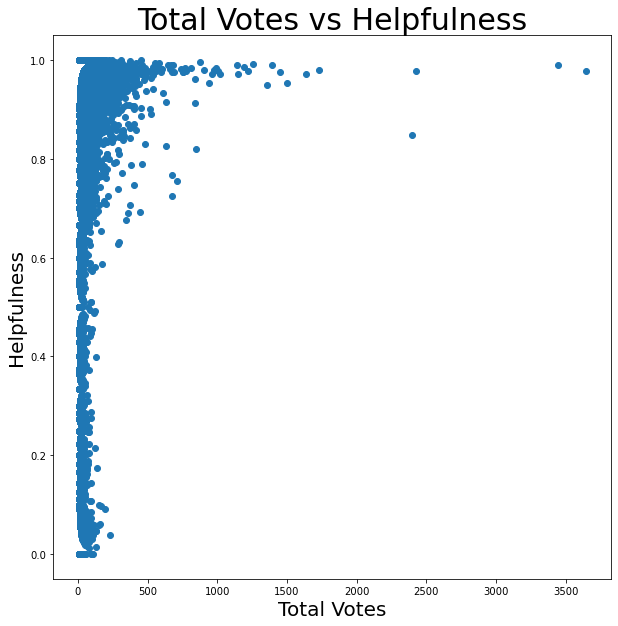

In [7]:
fig, axc = plt.subplots(figsize=(10, 10))
axc.scatter(df.total_votes, df.helpfulness)

axc.set_title('Total Votes vs Helpfulness', fontsize= 30)
axc.set_xlabel('Total Votes', fontsize= 20)
axc.set_ylabel('Helpfulness', fontsize= 20)

There definitely seems to be a correlation. The more votes a review has, the higher the likelihood it the review is positively scored as helpful. It would not benefit our modeling to skew the dataset one way or the other, helpful or unhelpful. We can cut away those reviews that have a large number of votes.

In [8]:
df = df[df.total_votes <= 100]
df.reset_index(drop=True, inplace=True)
len(df)

62666

Placing a cieling of 100 votes does not significantly impact the amount of data we have towrk with, or at least not nearly as significantly as placing the floor value. 

If we make a scatterplot of this new zoomed in picture, we can make out more detail.

Text(0, 0.5, 'Helpfulness')

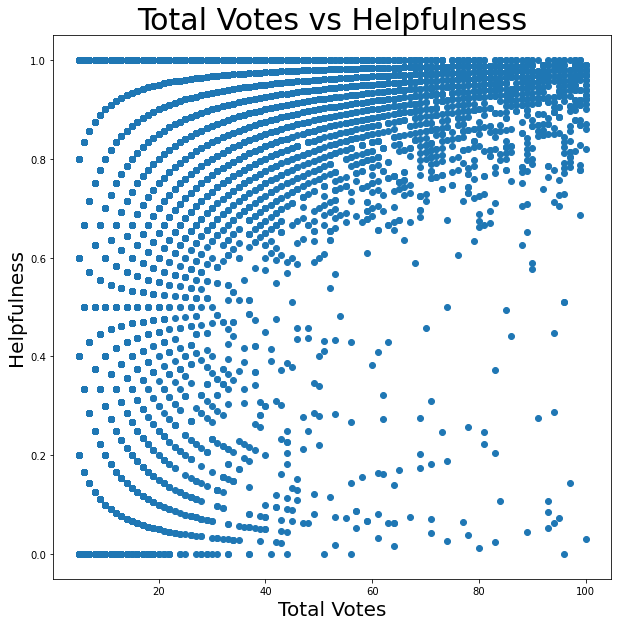

In [9]:
fig, axc = plt.subplots(figsize=(10, 10))
axc.scatter(df.total_votes, df.helpfulness)

axc.set_title('Total Votes vs Helpfulness', fontsize= 30)
axc.set_xlabel('Total Votes', fontsize= 20)
axc.set_ylabel('Helpfulness', fontsize= 20)

Now we can clearly see patterns emerge and pose interpretations on them. 

As we move along the total votes axis, we see that review helpfulness ratings follow a kind of logarithmic curve. The curves tend high, center, or low depending on starting position. It would appear that reviews that are judged as helpful, unhelpful, or neutral early on tend towards those respective helpfulness ratings the more votes are amassed. However, only the reviews that tend toward the positive helpful rating continue to gain in total votes while non-helpful review curves fade off. There are many possible explanations for this. 

* Review readers are less inclined to issue negative votes. When faced with an unhelpful review, readers are more hesitant or less motivated to pass judgement. This may also help explain the vast numbers of unrated reviews.  
* Amazon senses which reviews are trending as helpful and disproportionality gives them more exposure to the review readers in an effort to maximize usefulness and help customers. By the same token, reviews that begin trending unhelpful are hidden away or buried to the point that readers will barely see them, nevermind vote on them.

The implication of these trends is that the majority of reviews in the usable dataset are skewed towards high helpfulness rating. It may seem from the above graph that we could lower our total votes ceiling to bring the spread of helpful to unhelpful reviews closer to the center, but the 2D histogram of the same variables shows that this would be futile.


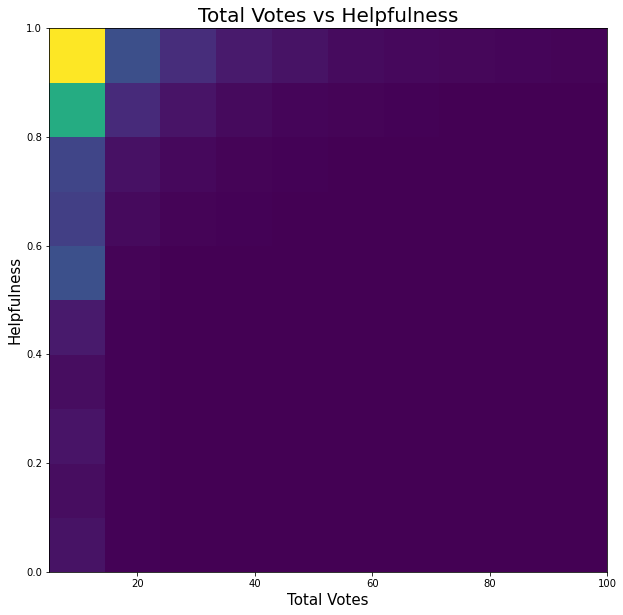

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist2d(df.total_votes, df.helpfulness)
ax.set_title('Total Votes vs Helpfulness', fontsize= 20)
ax.set_xlabel('Total Votes', fontsize= 15)
ax.set_ylabel('Helpfulness', fontsize= 15)
plt.show();

The dataset is concentrated in the region of low number of votes, high helpfulness rating. We are not going to achieve an evenly helpfulness rating by filtering away anymore of our data so we can stop here. 

However, we are doing a binary classification problem and need to label each review as either helpful or unhelpful in such a way that both classes are balanced in number of dataset entries. To achieve this we will impose a high helpfulness rating cutoff standard for our labeling. In the following code block we label our data with a new a new column "helpful" taking on values of either 0 or 1 indicating if a review is helpful or not. We also print the percentage distribution of the two cases in the dataset.  


In [11]:
df["helpful"] = np.where(df["helpfulness"] >= .87, 1, 0) 
df.helpful.value_counts(normalize=True)

1    0.509814
0    0.490186
Name: helpful, dtype: float64

# Exploration

In this section we map the binary helpful value of the review against some high level and meta traits to see if we can gain insight that may help guide our analysis. In the first plot we have a 2D histogram of review length vs helpful. The histogram is just two rows of blocks showing the density spread of the reviews among the given axis. Any discrepancy in colorization will tell us if there is a correlation between the length of the review and whether or not it is labeled as helpful. 

(0.0, 2000.0, 0.0, 1.0)

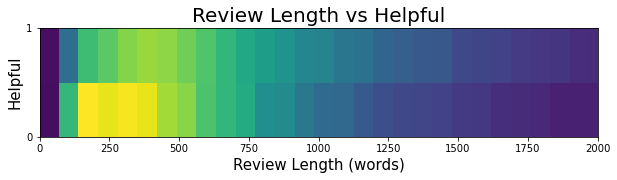

In [12]:
df['textLength'] = [len(df.loc[row, 'reviewText']) for row in df.index]
fig, ax = plt.subplots(figsize = (10, 2))
ax.hist2d(df.textLength, df.helpful, bins=(300, 2))
ax.set_title('Review Length vs Helpful', fontsize= 20)
ax.set_xlabel('Review Length (words)', fontsize= 15)
ax.set_ylabel('Helpful', fontsize= 15)
plt.yticks(range(0,2))
plt.axis([0, 2000, 0, 1])

We can see that the majority of reviews are centered around the 300 word count area for both helpful and non helpful reviews. Reviews labeled helpful do definitely do tend to be slightly longer than their unhelpful counterparts however. The difference is not huge but it is there.

In the next bit of exploration we introduce the concept of "readability" through the textstat library. Readability is the measure of how complex a piece of text is. The higher the score a text gets, the higher the level of education necessary for proper comprehension. There are many different models for measuring readability of text and textstat implements a wide array of them. For this exploration we used Automated Readability Index (AIR). AIR uses an equation that relates the ratios of characters to words and words to sentences to assign a score that approximates a school grade level. 

After evaluating all of the review texts based on AIR we can see in the results that there is hardly any difference distinction in the histogram. Most reviews helpful and unhelpful fall under the 6th to 9th grade readability level. 

(0.0, 20.0, 0.0, 1.0)

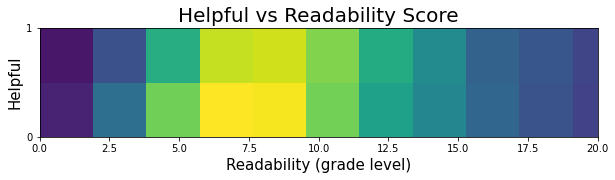

In [13]:
import textstat

df['readability'] = [textstat.automated_readability_index(df.loc[row, 'reviewText']) for row in df.index]
fig, ax = plt.subplots(figsize = (10, 2))
ax.hist2d(df.readability, df.helpful, bins=(900, 2))
ax.set_title('Helpful vs Readability Score', fontsize= 20)
ax.set_xlabel('Readability (grade level)', fontsize= 15)
ax.set_ylabel('Helpful', fontsize= 15)
plt.yticks(range(0,2))
plt.axis([0, 20, 0, 1])

One more bit of exploration we will conduct is to compare the "overall" field of the review with helpful. Overall represents the out-of-five quantifiable score that the reviewer issued to the product. 

This histogram has some interesting information. It shows that the vast majority of product reviews in our data are overwhelmingly positive toward their products. It seems that as with the helpful votes, people are by in large much more inclined to pass positive judgment rather than negative. It may also give indicate that Amazon customers are generally very satisfied with their shopping experience. 

In any case, there is a discernible difference in the helpful and unhelpful spreads. Reviews labeled unhelpful do have a tilt towards unsatisfied reviews. Negative reviews attract more unhelpful votes. Without considering too deeply the psychological or business analytics implications here, one idea that we can come out of this with is this. Review text with language or vocabulary that lean positive/negative, happy/unhappy may hold some predictive power over helpful/unhelpful labeling of a review.   

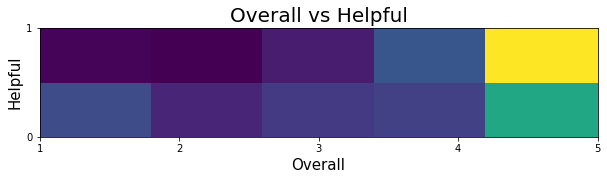

In [14]:
fig, ax = plt.subplots(figsize = (10, 2))
ax.hist2d(df.overall, df.helpful, bins=(5, 2))

ax.set_title('Overall vs Helpful', fontsize= 20)
ax.set_xlabel('Overall', fontsize= 15)
ax.set_ylabel('Helpful', fontsize= 15)
plt.yticks(range(0,2))
plt.xticks(range(1,6))
plt.show();

One way we can investigate this conjecture is through sentiment analysis. Sentiment refers to a measure of positivity/negativity of a text. The TextBlob library offers a basic sentiment evaluation that we can use to label the review data. The out put is on a scale from -1 to 1, -1 signifying a negative sentiment and 1 signifying positive. 

The results seem to mimic those of the "overall" exploration. Reviews labeled helpful do skew a bit more into the positive range, and reviews labeled unhelpful skew more negative. Both however are centered in just about the same place, right in the neutral/mildly positive region of around .2. 

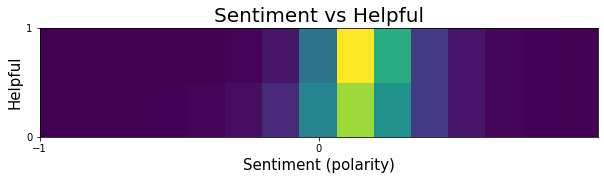

In [15]:
from textblob import TextBlob

df['sentiment'] = [TextBlob(df.loc[row, 'reviewText']).sentiment.polarity for row in df.index]

fig, ax = plt.subplots(figsize = (10, 2))
ax.hist2d(df.sentiment, df.helpful, bins=(15, 2))

ax.set_title('Sentiment vs Helpful', fontsize= 20)
ax.set_xlabel('Sentiment (polarity)', fontsize= 15)
ax.set_ylabel('Helpful', fontsize= 15)
plt.yticks(range(0,2))
plt.xticks(range(-1,1))
plt.show();

# Random Forest

We are conducting this as a binary classification problem. That means that a review is either helpful or not. In order to properly label a review as helpful or not, we must choose a cuttoff point in the continuous helpfulness variable. All reviews at and above that point are considered helpful and reviews below that point are considered not helpful. 

We choose .86 as our cutoff because it very nearly splits the set of reviews into two evenly sized subsets. That is, there are just about as many helpful reviews as there are not helpful reviews. This perfect balance in the dataset will help prevent noise and bias in our model training. 

We split the labeled dataset into training and test subsets. The percentage split is 80-20. 

In [16]:
from sklearn.model_selection import train_test_split

x = df['reviewText']
y = df['helpful']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state = 100)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

1    0.509595
0    0.490405
Name: helpful, dtype: float64
1    0.510691
0    0.489309
Name: helpful, dtype: float64


In [17]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

stop_list = stopwords.words('english')
stop_list += list(string.punctuation)
stop_list += ['br', '.<', '..', '...', '``', "''", '--']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


A countvectorizer object is an object that can transform an input text into a vector of word counts where each vector index represents a distinct word. The words that the indicies represent depend on the settup of the countvectorizer object itself, not necesarilly the input text.

First the countvectorizer object is instantiated with certain properties. In our case, we have three specifications: we want the count to be based on bigrams or adjacent word pairs, we want to ignore any bigrams with words in the stop list, and we want to limit our vectors to only 100 bigrams. 

To tell the countvectorizer which bigrams speficially to look for when creating a vector, we run the method fit(X) on it where X is a collection of texts. As we have chosen to limit ourselves to 100 bigrams, countvectorizer will look through all texts in sample and see which are the 100 most used bigrams throughout the entire group and set those as the vectorizer bigrams.

Now we run transform(Z) on countvectorizer where Z is a collection of texts. Countvectorizer will return a collection of count-vectors, corresponding to each of the Z texts. Every count-vectors respresent the counts of those top 100 bigrams from the fit phase on the text from Z. So there is an important distinction here that in in the fit phase, all texts from X are used together to form the top 100 bigrams but in the transform phase, each text is individually vectorized. That is the basics of CountVectorizer. 

In this code block we are using a Pipline to as a code shortcut to succinctly create a random forest classifier with count vectorizer as a preprocessing step. When fit is called on pipe_bigram_rf, a few things happen. Fit_transform is called on the countvectorizer with X_train as the input. This method does both fit and then transform on the same set of texts in X_Train. The result is an array of count vectorizers that we can call X_train_transformed. The the method fit is then called on random forest classifier object with X_train_transformed and y_train as input. 

Whats happened is we have transformed X_train from a array of review texts, to a array of vector-counts. An array of reviews is just an array of reviews, it has no features from which we can train our random forest. Vectorcounts on the other hand are vectors or collections of values. They have distinct features, namely the bigram counts on each of the reviews. These are objects we can train a random forest on. We have engineered features from texts to train our random forest models.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

pipe_bigram_rf = Pipeline([('vectorizer', CountVectorizer(stop_words = stop_list,
                                                          max_features = 300)),
                        ('forest', RandomForestClassifier(n_estimators=100,
                                                          n_jobs=-1))])
pipe_bigram_rf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=300,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('forest', RandomForestClassifier(n_jobs=-1))])

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred_train = pipe_bigram_rf.predict(X_test)
print('Training accuracy:', accuracy_score(y_test, y_pred_train))

Training accuracy: 0.6066698579862774


In [20]:
def vector_forest(df):
    x = df['reviewText']
    y = df['helpful']
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state = 100)
    train_test_split(x, y, test_size=.2, random_state = 100)
    print(y_train.value_counts(normalize=True))
    print(y_test.value_counts(normalize=True))

    pipe_bigram_rf = Pipeline([('vectorizer', CountVectorizer(stop_words = stop_list, 
                                                              max_features = 300)),
                            ('forest', RandomForestClassifier(n_estimators=100,
                                                              n_jobs=-1))])
    pipe_bigram_rf.fit(X_train, y_train)

    y_pred_train = pipe_bigram_rf.predict(X_test)
    print('Training accuracy:', accuracy_score(y_test, y_pred_train))

In [21]:
print("Hardware: ")
dfHardware = df[df.category=="Hardware"].copy()
dfHardware["helpful"] = np.where(dfHardware["helpfulness"] >= .89, 1, 0) 
dfHardware.helpful.value_counts(normalize=True)
print(len(dfHardware))
print(dfHardware.helpful.value_counts(normalize=True))
print()

print("Beauty: ")
dfBeauty = df[df.category=="Beauty"].copy()
dfBeauty["helpful"] = np.where(dfBeauty["helpfulness"] >= .82, 1, 0) 
dfBeauty.helpful.value_counts(normalize=True)
print(len(dfBeauty))
print(dfBeauty.helpful.value_counts(normalize=True))
print()

print("Games: ")
dfGames = df[df.category=="Games"].copy()
dfGames["helpful"] = np.where(dfGames["helpfulness"] >= .88, 1, 0) 
dfGames.helpful.value_counts(normalize=True)
print(len(dfGames))
print(dfGames.helpful.value_counts(normalize=True))
print()

print("Pets: ")
dfPets = df[df.category=="Pets"].copy()
dfPets["helpful"] = np.where(dfPets["helpfulness"] >= .92, 1, 0) 
dfPets.helpful.value_counts(normalize=True)
print(len(dfPets))
print(dfPets.helpful.value_counts(normalize=True))
print()

Hardware: 
18325
1    0.518254
0    0.481746
Name: helpful, dtype: float64

Beauty: 
19070
0    0.500682
1    0.499318
Name: helpful, dtype: float64

Games: 
15549
1    0.504727
0    0.495273
Name: helpful, dtype: float64

Pets: 
9722
0    0.508537
1    0.491463
Name: helpful, dtype: float64



In [22]:
print("Hardware:")
vector_forest(dfHardware)
print()

print("Beauty:")
vector_forest(dfBeauty)
print()

print("Games:")
vector_forest(dfGames)
print()

print("Pets:")
vector_forest(dfPets)
print()

Hardware:
1    0.518963
0    0.481037
Name: helpful, dtype: float64
1    0.515416
0    0.484584
Name: helpful, dtype: float64
Training accuracy: 0.5950886766712142

Beauty:
0    0.500459
1    0.499541
Name: helpful, dtype: float64
0    0.501573
1    0.498427
Name: helpful, dtype: float64
Training accuracy: 0.5875721027792344

Games:
1    0.50816
0    0.49184
Name: helpful, dtype: float64
0    0.509003
1    0.490997
Name: helpful, dtype: float64
Training accuracy: 0.5848874598070739

Pets:
0    0.505593
1    0.494407
Name: helpful, dtype: float64
0    0.520308
1    0.479692
Name: helpful, dtype: float64
Training accuracy: 0.5840616966580977



In [23]:
#First idea, adding entry to reviews with all descriptive words

# def get_adjectives(text):
#     blob = TextBlob(text)
#     return [ word for (word,tag) in blob.tags if (tag.startswith("JJ") or tag.startswith("RB"))]

# dfDescriptors = df['reviewText'].apply(get_adjectives)

In [24]:
import nltk
nltk.download('words')
from nltk.corpus import words

all_words = words.words()
non_descriptive_words = []
for word in all_words:
    blob = TextBlob(word)
    word, tag = blob.tags[0]
    if(not (tag.startswith("JJ") or tag.startswith("RB"))):
        non_descriptive_words.append(word)

len(non_descriptive_words)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Ed\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


191440

In [25]:
pipe_bigram_rf = Pipeline([('vectorizer', CountVectorizer(stop_words = non_descriptive_words, 
                                                          max_features = 300)),
                        ('forest', RandomForestClassifier(n_estimators=100,
                                                          n_jobs=-1))])
pipe_bigram_rf.fit(X_train, y_train)

y_pred_train = pipe_bigram_rf.predict(X_test)
print('Training accuracy:', accuracy_score(y_test, y_pred_train))

C:\Users\Ed\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aani', 'aaron', 'aaronite', 'aaru', 'ab', 'ababdeh', 'ababua', 'abadite', 'abama', 'abantes', 'abarambo', 'abaris', 'abasgi', 'abassin', 'abatua', 'abba', 'abbie', 'abby', 'abderite', 'abdiel', 'abdominales', 'abe', 'abel', 'abelia', 'abelicea', 'abencerrages', 'aberdeen', 'aberia', 'abhorson', 'abie', 'abies', 'abietineae', 'abiezer', 'abipon', 'abitibi', 'abkhas', 'ablepharus', 'abnaki', 'abner', 'abo', 'abobra', 'abongo', 'abraham', 'abrahamic', 'abrahamidae', 'abrahamite', 'abram', 'abramis', 'abranchiata', 'abrocoma', 'abroma', 'abronia', 'abrus', 'absalom', 'absaroka', 'absi', 'absyrtus', 'abundantia', 'abuta', 'abutilon', 'acacia', 'academic', 'academus', 'acadia', 'acadie', 'acaena', 'acalepha', 'acalephae', 'acalypha', 'acalypterae', 'acalyptrata', 'acalyptratae', 'acamar', 'acanth

Training accuracy: 0.5928674006701771
